In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Tải dữ liệu
input_path = '/kaggle/input'
train_file = os.path.join(input_path, 'child-mind-institute-problematic-internet-use/train.csv')
test_file = os.path.join(input_path, 'child-mind-institute-problematic-internet-use/test.csv')

train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

In [2]:
# Tách cột ID và cột mục tiêu
id_column = test_df['id']
test_df = test_df.drop(columns=['id'])
train_df = train_df.drop(columns=['id'])

# Xử lý cột mục tiêu
target = train_df.pop('sii')

# Loại bỏ các dòng có giá trị mục tiêu bị thiếu
valid_indices = target.notna()  # Chỉ giữ các chỉ số hợp lệ
train_df = train_df[valid_indices]
target = target[valid_indices]

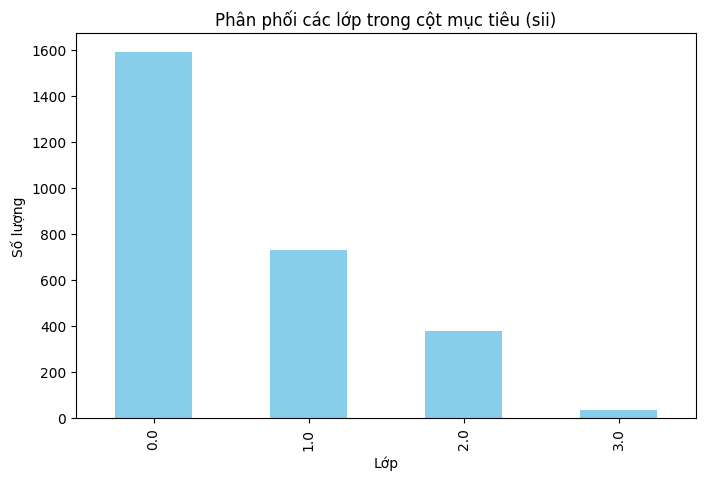

In [3]:
# Biểu đồ kiểm tra cân bằng dữ liệu
plt.figure(figsize=(8, 5))
target.value_counts().plot(kind='bar', color='skyblue')
plt.title('Phân phối các lớp trong cột mục tiêu (sii)')
plt.xlabel('Lớp')
plt.ylabel('Số lượng')
plt.show()


In [4]:
# Mã hóa các biến phân loại
for col in train_df.columns:
    if train_df[col].dtype == 'object':
        train_df[col], _ = pd.factorize(train_df[col])
for col in test_df.columns:
    if test_df[col].dtype == 'object':
        test_df[col], _ = pd.factorize(test_df[col])

# Điền giá trị thiếu bằng trung vị
train_df.fillna(train_df.median(), inplace=True)
test_df.fillna(test_df.median(), inplace=True)

# Đồng bộ hóa các cột giữa dữ liệu huấn luyện và kiểm tra
common_columns = train_df.columns.intersection(test_df.columns)
train_df = train_df[common_columns]
test_df = test_df[common_columns]

# Chuẩn hóa dữ liệu
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(train_df)
X_test = scaler.transform(test_df)

In [5]:
# Huấn luyện Random Forest để lấy tầm quan trọng đặc trưng
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, target)

# Tầm quan trọng của các đặc trưng
feature_importances = rf_model.feature_importances_

# Sắp xếp tầm quan trọng đặc trưng giảm dần
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = [common_columns[i] for i in sorted_indices]
sorted_importances = feature_importances[sorted_indices]


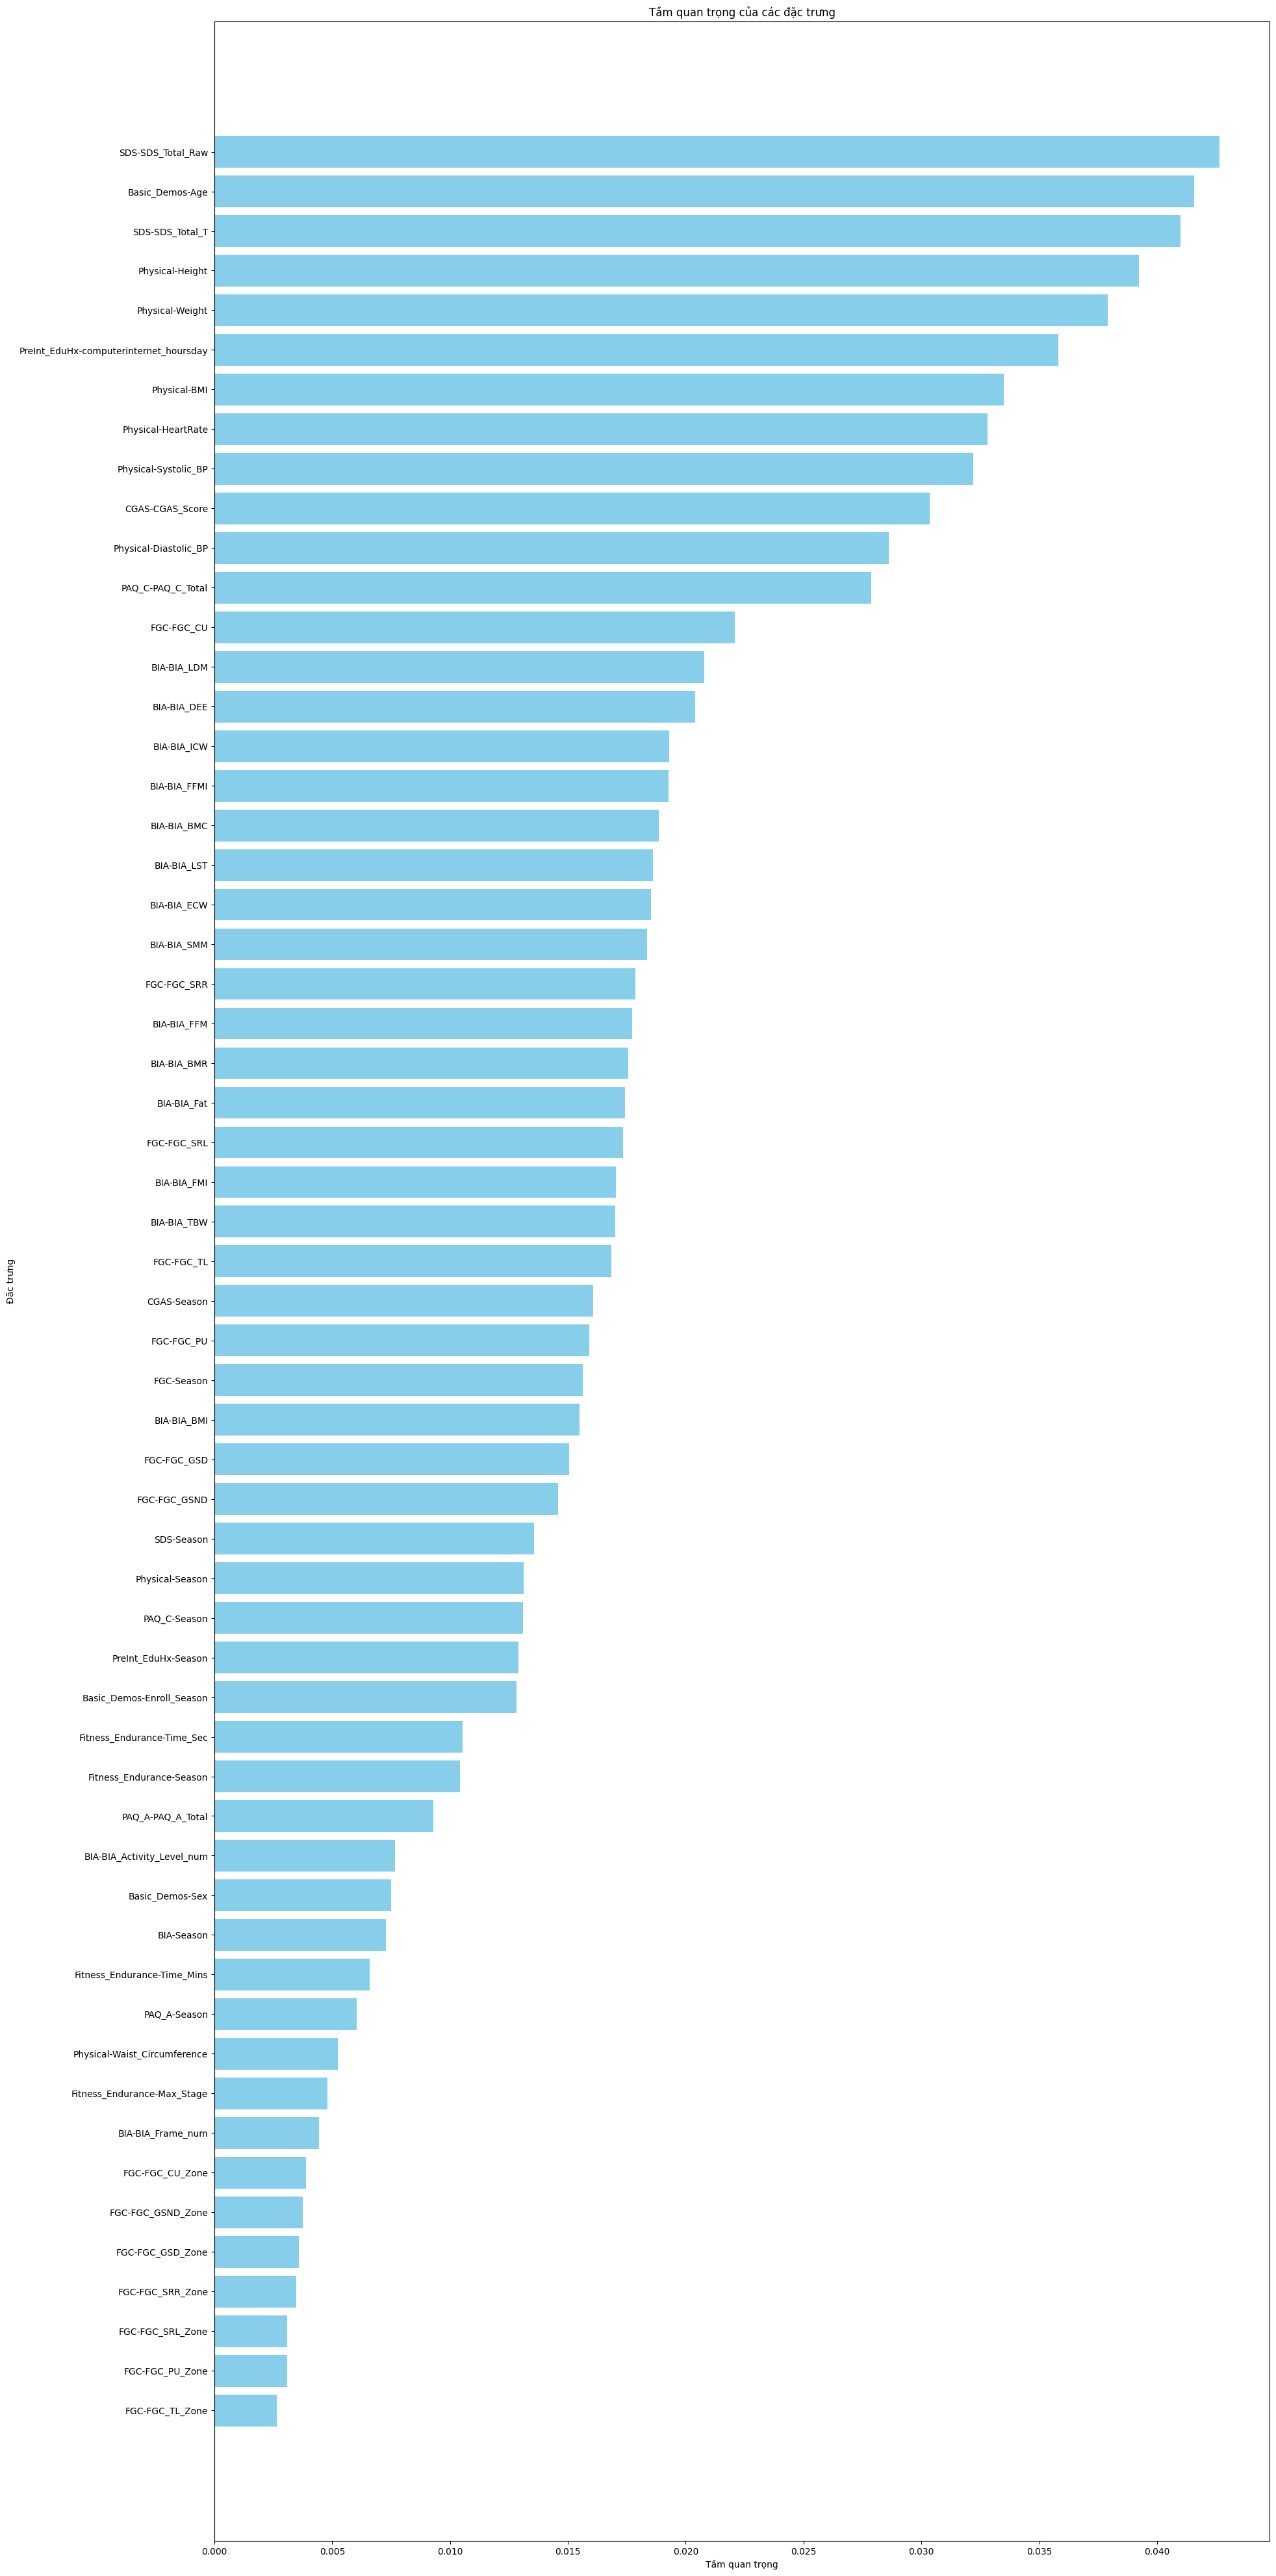

In [6]:
# Vẽ biểu đồ tầm quan trọng đặc trưng
plt.figure(figsize=(20, 40))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Tầm quan trọng')
plt.ylabel('Đặc trưng')
plt.title('Tầm quan trọng của các đặc trưng')
plt.gca().invert_yaxis()
plt.tight_layout(pad=2.0)
plt.show()

In [7]:
# In các đặc trưng có tầm quan trọng lớn hơn 0.01
important_features = [feature for feature, importance in zip(sorted_features, sorted_importances) if importance > 0.01]
print("\nCác đặc trưng có tầm quan trọng lớn hơn 0.01:")
print(important_features)


Các đặc trưng có tầm quan trọng lớn hơn 0.01:
['SDS-SDS_Total_Raw', 'Basic_Demos-Age', 'SDS-SDS_Total_T', 'Physical-Height', 'Physical-Weight', 'PreInt_EduHx-computerinternet_hoursday', 'Physical-BMI', 'Physical-HeartRate', 'Physical-Systolic_BP', 'CGAS-CGAS_Score', 'Physical-Diastolic_BP', 'PAQ_C-PAQ_C_Total', 'FGC-FGC_CU', 'BIA-BIA_LDM', 'BIA-BIA_DEE', 'BIA-BIA_ICW', 'BIA-BIA_FFMI', 'BIA-BIA_BMC', 'BIA-BIA_LST', 'BIA-BIA_ECW', 'BIA-BIA_SMM', 'FGC-FGC_SRR', 'BIA-BIA_FFM', 'BIA-BIA_BMR', 'BIA-BIA_Fat', 'FGC-FGC_SRL', 'BIA-BIA_FMI', 'BIA-BIA_TBW', 'FGC-FGC_TL', 'CGAS-Season', 'FGC-FGC_PU', 'FGC-Season', 'BIA-BIA_BMI', 'FGC-FGC_GSD', 'FGC-FGC_GSND', 'SDS-Season', 'Physical-Season', 'PAQ_C-Season', 'PreInt_EduHx-Season', 'Basic_Demos-Enroll_Season', 'Fitness_Endurance-Time_Sec', 'Fitness_Endurance-Season']


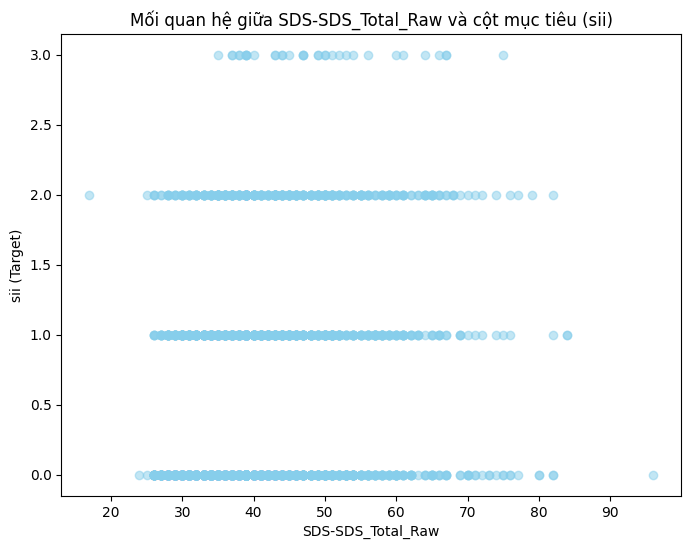

In [8]:
# Đặc trưng quan trọng nhất
most_important_feature = common_columns[np.argmax(feature_importances)]

# Vẽ mối quan hệ giữa đặc trưng quan trọng nhất và cột mục tiêu
plt.figure(figsize=(8, 6))
plt.scatter(train_df[most_important_feature], target, alpha=0.5, color='skyblue')
plt.xlabel(most_important_feature)
plt.ylabel('sii (Target)')
plt.title(f'Mối quan hệ giữa {most_important_feature} và cột mục tiêu (sii)')
plt.show()


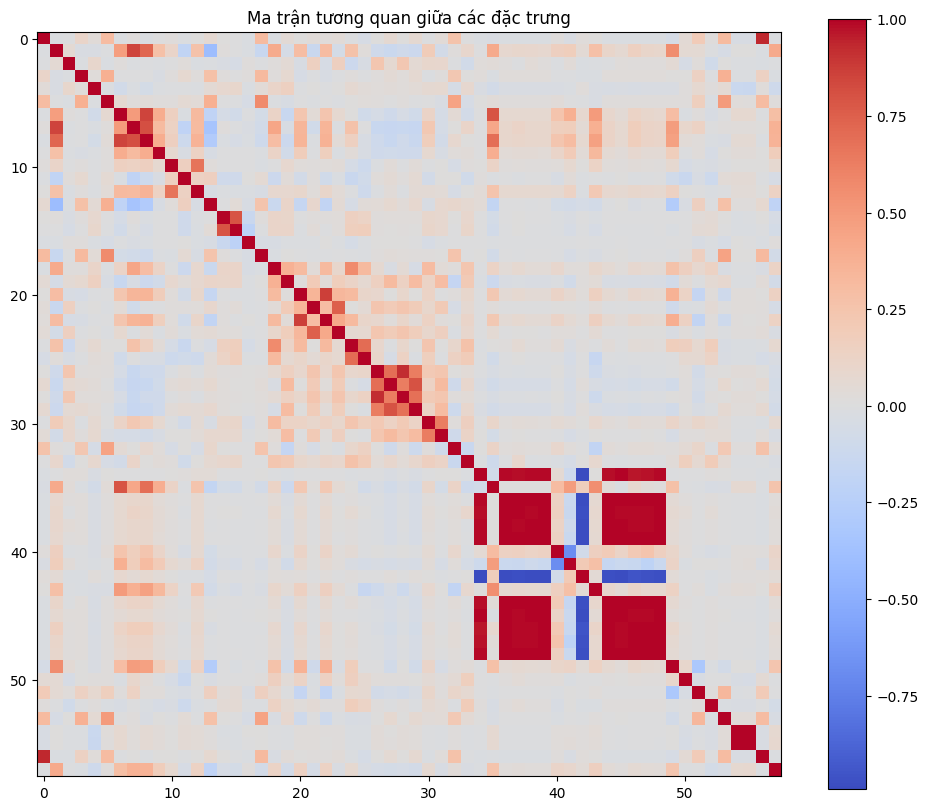

In [9]:
# Vẽ biểu đồ ma trận tương quan
correlation_matrix = train_df.corr()
plt.figure(figsize=(12, 10))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Ma trận tương quan giữa các đặc trưng')
plt.show()